In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
import tensorflow as tf
import keras
from keras.models import Sequential #the model is built adding layers one after the other
from keras.layers import Dense #fully connected layers: every output talks to every input
from keras.layers import Dropout
from keras_tuner.tuners import RandomSearch
from tensorflow.keras import layers
from keras import backend as K
import os, random

os.environ["PYTHONHASHSEED"] = "14"
random.seed(14)
np.random.seed(14)
tf.random.set_seed(14)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/kalharaperera/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
2026-01-03 10:12:12.263254: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import matplotlib
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 150)

font = {'size'   : 16}
matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
matplotlib.rcParams['figure.dpi'] = 300

In [3]:
excel_path = 'Data/pca_results.xlsx'   # input file
#sheet_name = 'standard chrons'                 # sheet with data
header_row = 0                                  # 0-based row index for header (Excel row 2)
year_min, year_max = 1490, 1995
n_components = 30 

# Read Excel and keep only the needed columns
df = pd.read_excel(excel_path, header=header_row)

# Keep rows within the target year range
mask = (df['YEAR'] >= year_min) & (df['YEAR'] <= year_max)
df_years = df.loc[mask].copy()

# Set YEAR as index 
df_years = df_years.set_index('YEAR')

In [4]:
nf = pd.read_excel('Data/Measured Streamflow in MAF.xlsx', header=0, index_col=0)

target_col = "Meko Paper"
year_min, year_max = 1906, 1995

# 1) Make sure indices are numeric and sorted
nf = nf.copy()
df_years = df_years.copy()
nf.index = pd.to_numeric(nf.index, errors='coerce')
df_years.index = pd.to_numeric(df_years.index, errors='coerce')
nf = nf.sort_index()
df_years = df_years.sort_index()

# 2) Use only predictor/site columns (exclude 'YEAR' since it's the index)
site_cols = [c for c in df_years.columns if c != 'YEAR'][:1]

# 3) Slice by year and inner-join to align rows
X_raw = df_years.loc[year_min:year_max, site_cols]
y_raw = nf.loc[year_min:year_max, target_col]
data = X_raw.join(y_raw, how="inner").dropna(axis=0)
X = data[site_cols]
y = data[target_col]

In [5]:
X.shape

(90, 1)

In [6]:
X_,Y_ = shuffle(X,y, random_state = 14)
tength = int(len(Y_)/10)
X_train = X_.values[:8*tength,:]
y_train = Y_[:8*tength]

X_val = X_.values[8*tength:9*tength,:]
y_val = Y_[8*tength:9*tength]

X_test = X_.values[9*tength:,:]
y_test = Y_[9*tength:]

In [7]:
X_train.shape

(72, 1)

In [8]:
def r2_score(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))  # Residual sum of squares
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))  # Total sum of squares
    return 1 - ss_res / (ss_tot + K.epsilon()) 

def build_model(hp):
    model = keras.Sequential()
    n_features = 1
    model.add(layers.Input(shape=(n_features,)))
    for i in range(hp.Int('num_layers', 2, 6)): #We try between 2 and 6 layers
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=20, 
                                            max_value=30,
                                            step=1),
                               activation='relu'))
    model.add(layers.Dense(1, activation='linear')) #last one
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])), #And a few learning rates
        loss='mse',metrics = [r2_score])
    return model

In [9]:
tuner = RandomSearch(
    build_model,                # Model-building function
    objective='val_loss',        # Objective to minimize (or maximize)
    max_trials=40,               # How many different models to try
    executions_per_trial=3,      # Number of executions per trial
    directory='/Users/kalharaperera/Desktop/Projects/River reconstruction/reserach_final',          
    project_name='my_project__2',
    seed=14,            
    overwrite=True # Name of the project
)

2026-01-03 10:12:28.761785: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 6, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 30, 'step': 1, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 30, 'step': 1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [12]:
tuner.search(X_train, y_train,
             epochs=100, validation_data=(X_val, y_val), batch_size=32, verbose = 1,shuffle=False)

Trial 40 Complete [00h 00m 10s]
val_loss: 386625802.6666667

Best val_loss So Far: 5061645.166666667
Total elapsed time: 00h 06m 52s


In [13]:
best_hps = tuner.get_best_hyperparameters()[0]
model= tuner.hypermodel.build(best_hps)
#model.build(input_shape=(None,1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 27)                54        
                                                                 
 dense_4 (Dense)             (None, 22)                616       
                                                                 
 dense_5 (Dense)             (None, 26)                598       
                                                                 
 dense_6 (Dense)             (None, 29)                783       
                                                                 
 dense_7 (Dense)             (None, 1)                 30        
                                                                 
Total params: 2,081
Trainable params: 2,081
Non-trainable params: 0
_________________________________________________________________


In [14]:
bestnet = model.fit(X_train, y_train, validation_data= (X_val, y_val), epochs=500, batch_size=16,shuffle=False )

Epoch 1/500
5/5 [==============================] - 0s 24ms/step - loss: 383422208.0000 - r2_score: -21.6999 - val_loss: 390372608.0000 - val_r2_score: -11.8462
Epoch 2/500
5/5 [==============================] - 0s 6ms/step - loss: 383300416.0000 - r2_score: -21.6919 - val_loss: 390101888.0000 - val_r2_score: -11.8373
Epoch 3/500
5/5 [==============================] - 0s 6ms/step - loss: 382901120.0000 - r2_score: -21.6659 - val_loss: 389245888.0000 - val_r2_score: -11.8091
Epoch 4/500
5/5 [==============================] - 0s 6ms/step - loss: 381716448.0000 - r2_score: -21.5897 - val_loss: 386855040.0000 - val_r2_score: -11.7304
Epoch 5/500
5/5 [==============================] - 0s 6ms/step - loss: 378537792.0000 - r2_score: -21.3883 - val_loss: 380856672.0000 - val_r2_score: -11.5330
Epoch 6/500
5/5 [==============================] - 0s 6ms/step - loss: 370847616.0000 - r2_score: -20.9071 - val_loss: 367269248.0000 - val_r2_score: -11.0859
Epoch 7/500
5/5 [============================

In [16]:
model.evaluate(X_test, y_test)
model.evaluate(X_train, y_train)
model.evaluate(X,y)

3/3 [==============================] - 0s 938us/step - loss: 6088003.0000 - r2_score: 0.7643


[6088003.0, 0.7643141746520996]

3/3 [==============================] - 0s 919us/step


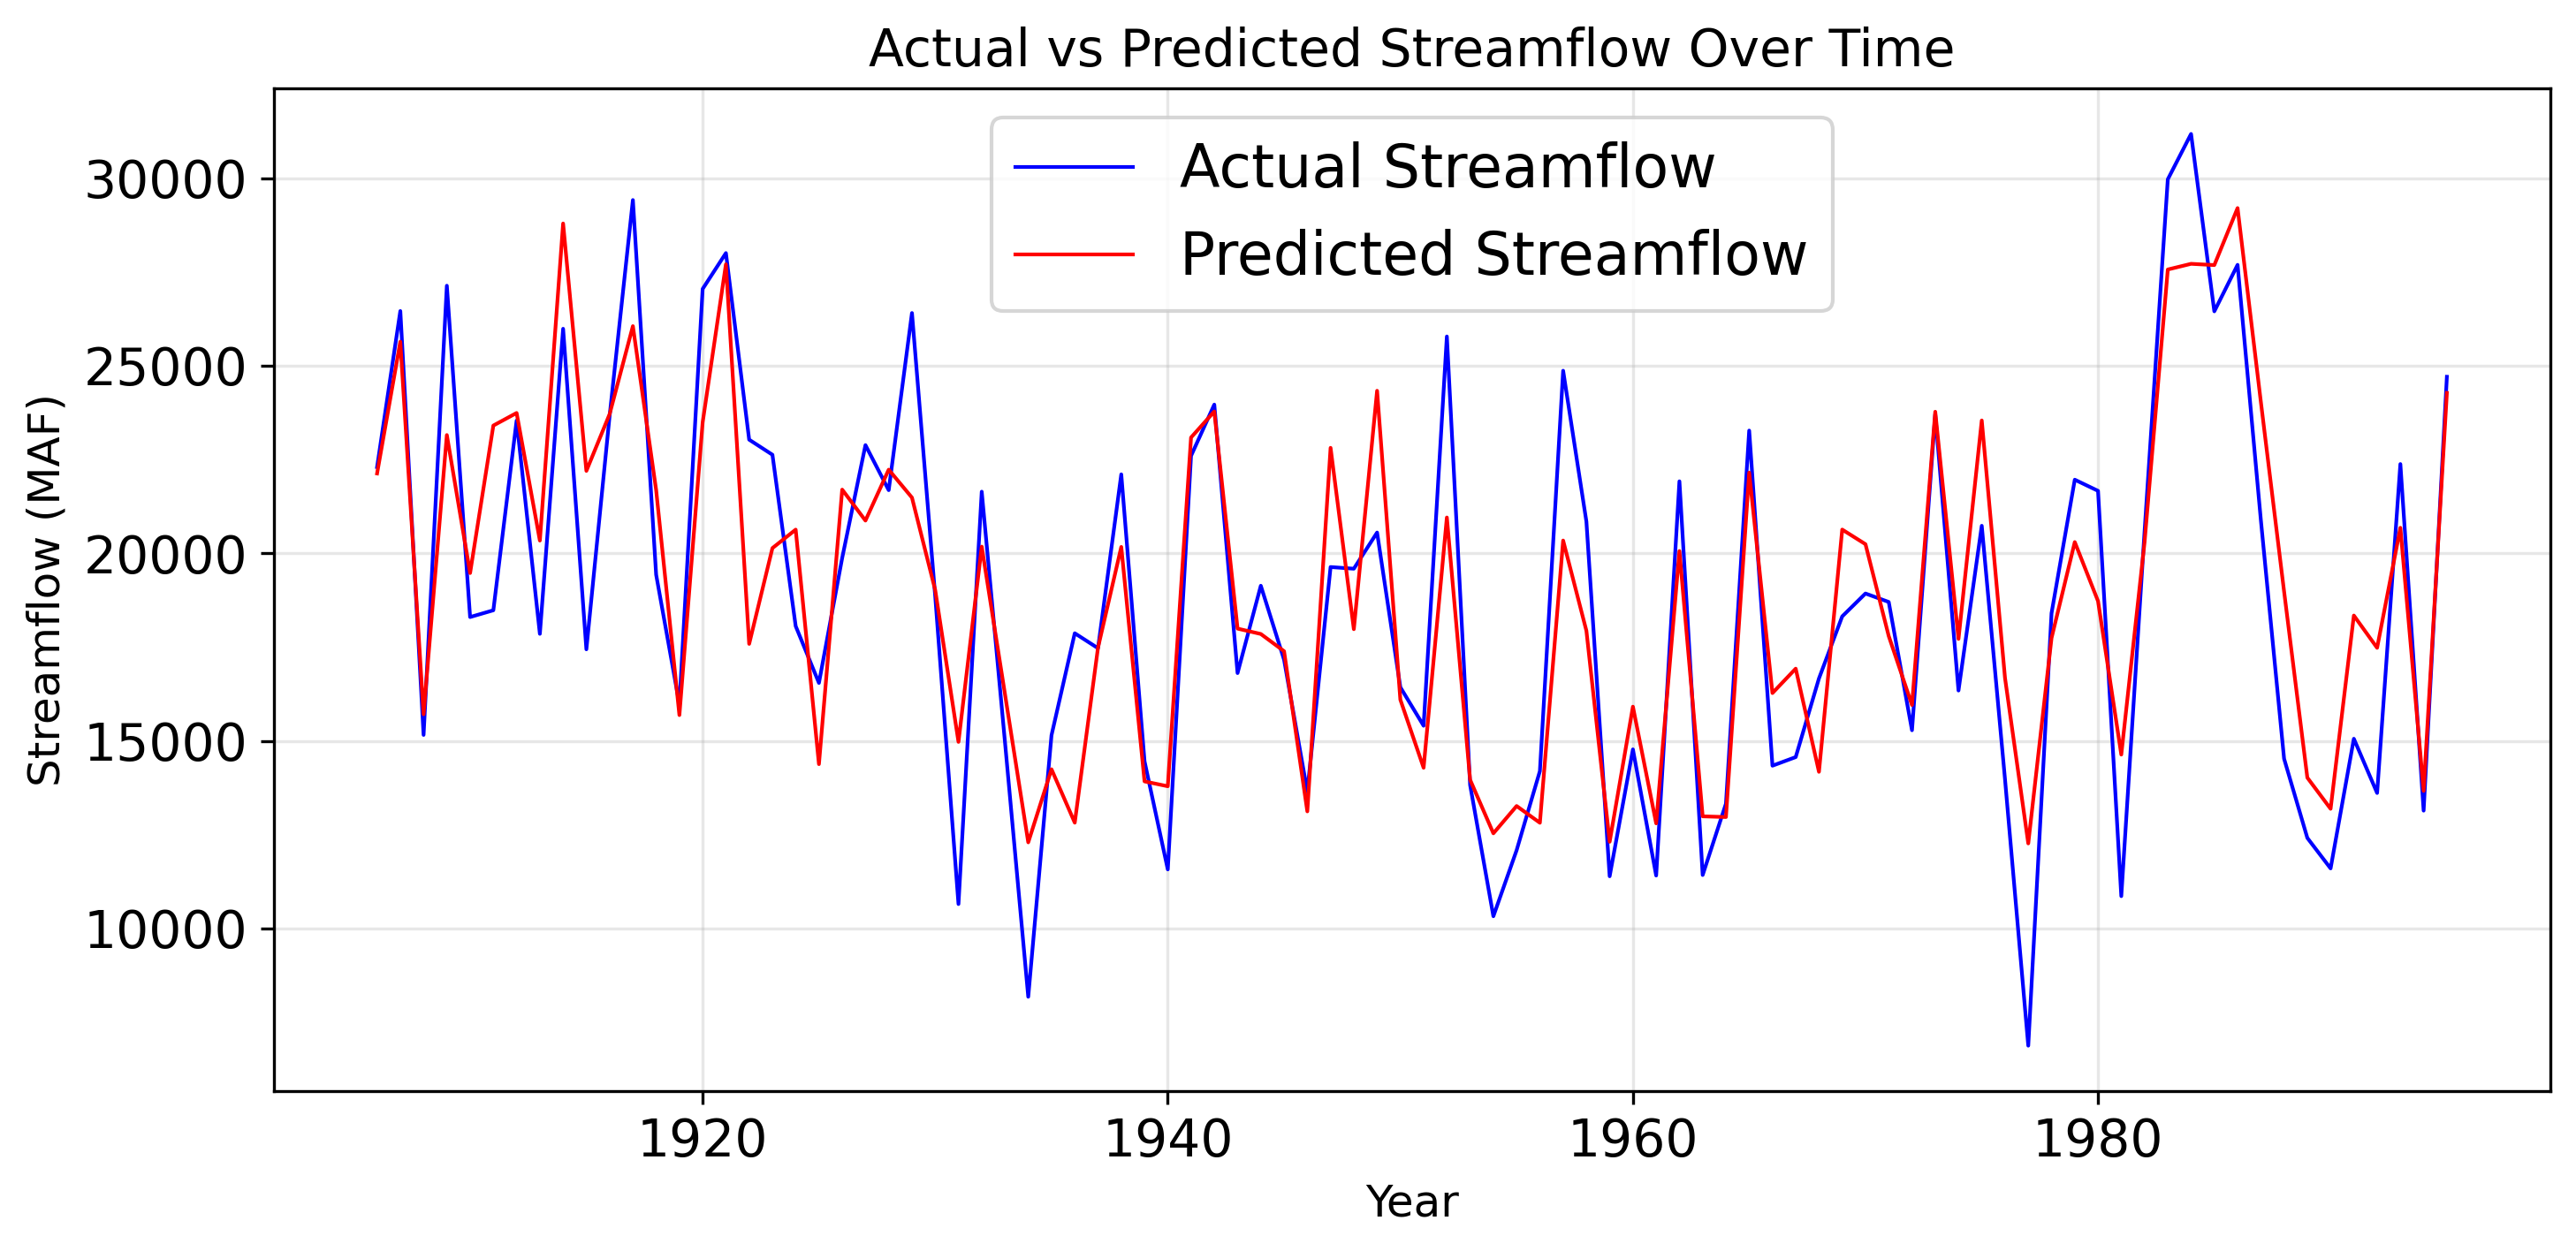

In [17]:
# Convert model predictions to Series with year index
y_pred = pd.Series(model.predict(X).flatten(), index=X.index, name="Predicted")

plt.figure(figsize=(10,5))

# Plot actual measured streamflow
plt.plot(y.index, y.values, label='Actual Streamflow', color='blue', linewidth=1)

# Plot NN predictions
plt.plot(y.index, y_pred.values, label='Predicted Streamflow', color='red', linewidth=1)

plt.xlabel('Year', fontsize=12)
plt.ylabel('Streamflow (MAF)', fontsize=12)
plt.title('Actual vs Predicted Streamflow Over Time', fontsize=14)
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [18]:
df_out = pd.DataFrame({
    'Year': y.index,
    'Observed_Streamflow': y_raw,
    'Predicted_Streamflow NN': y_pred
})

# Save to Excel
df_out.to_excel('Observed_vs_Predicted_Streamflow - NN.xlsx', index=False)

In [114]:
Z_all = df_years.copy()
Z_all.index = pd.to_numeric(Z_all.index, errors='coerce')
Z_all = Z_all.sort_index()

Z_pred = Z_all[site_cols].astype(np.float32)

16/16 [==============================] - 0s 551us/step


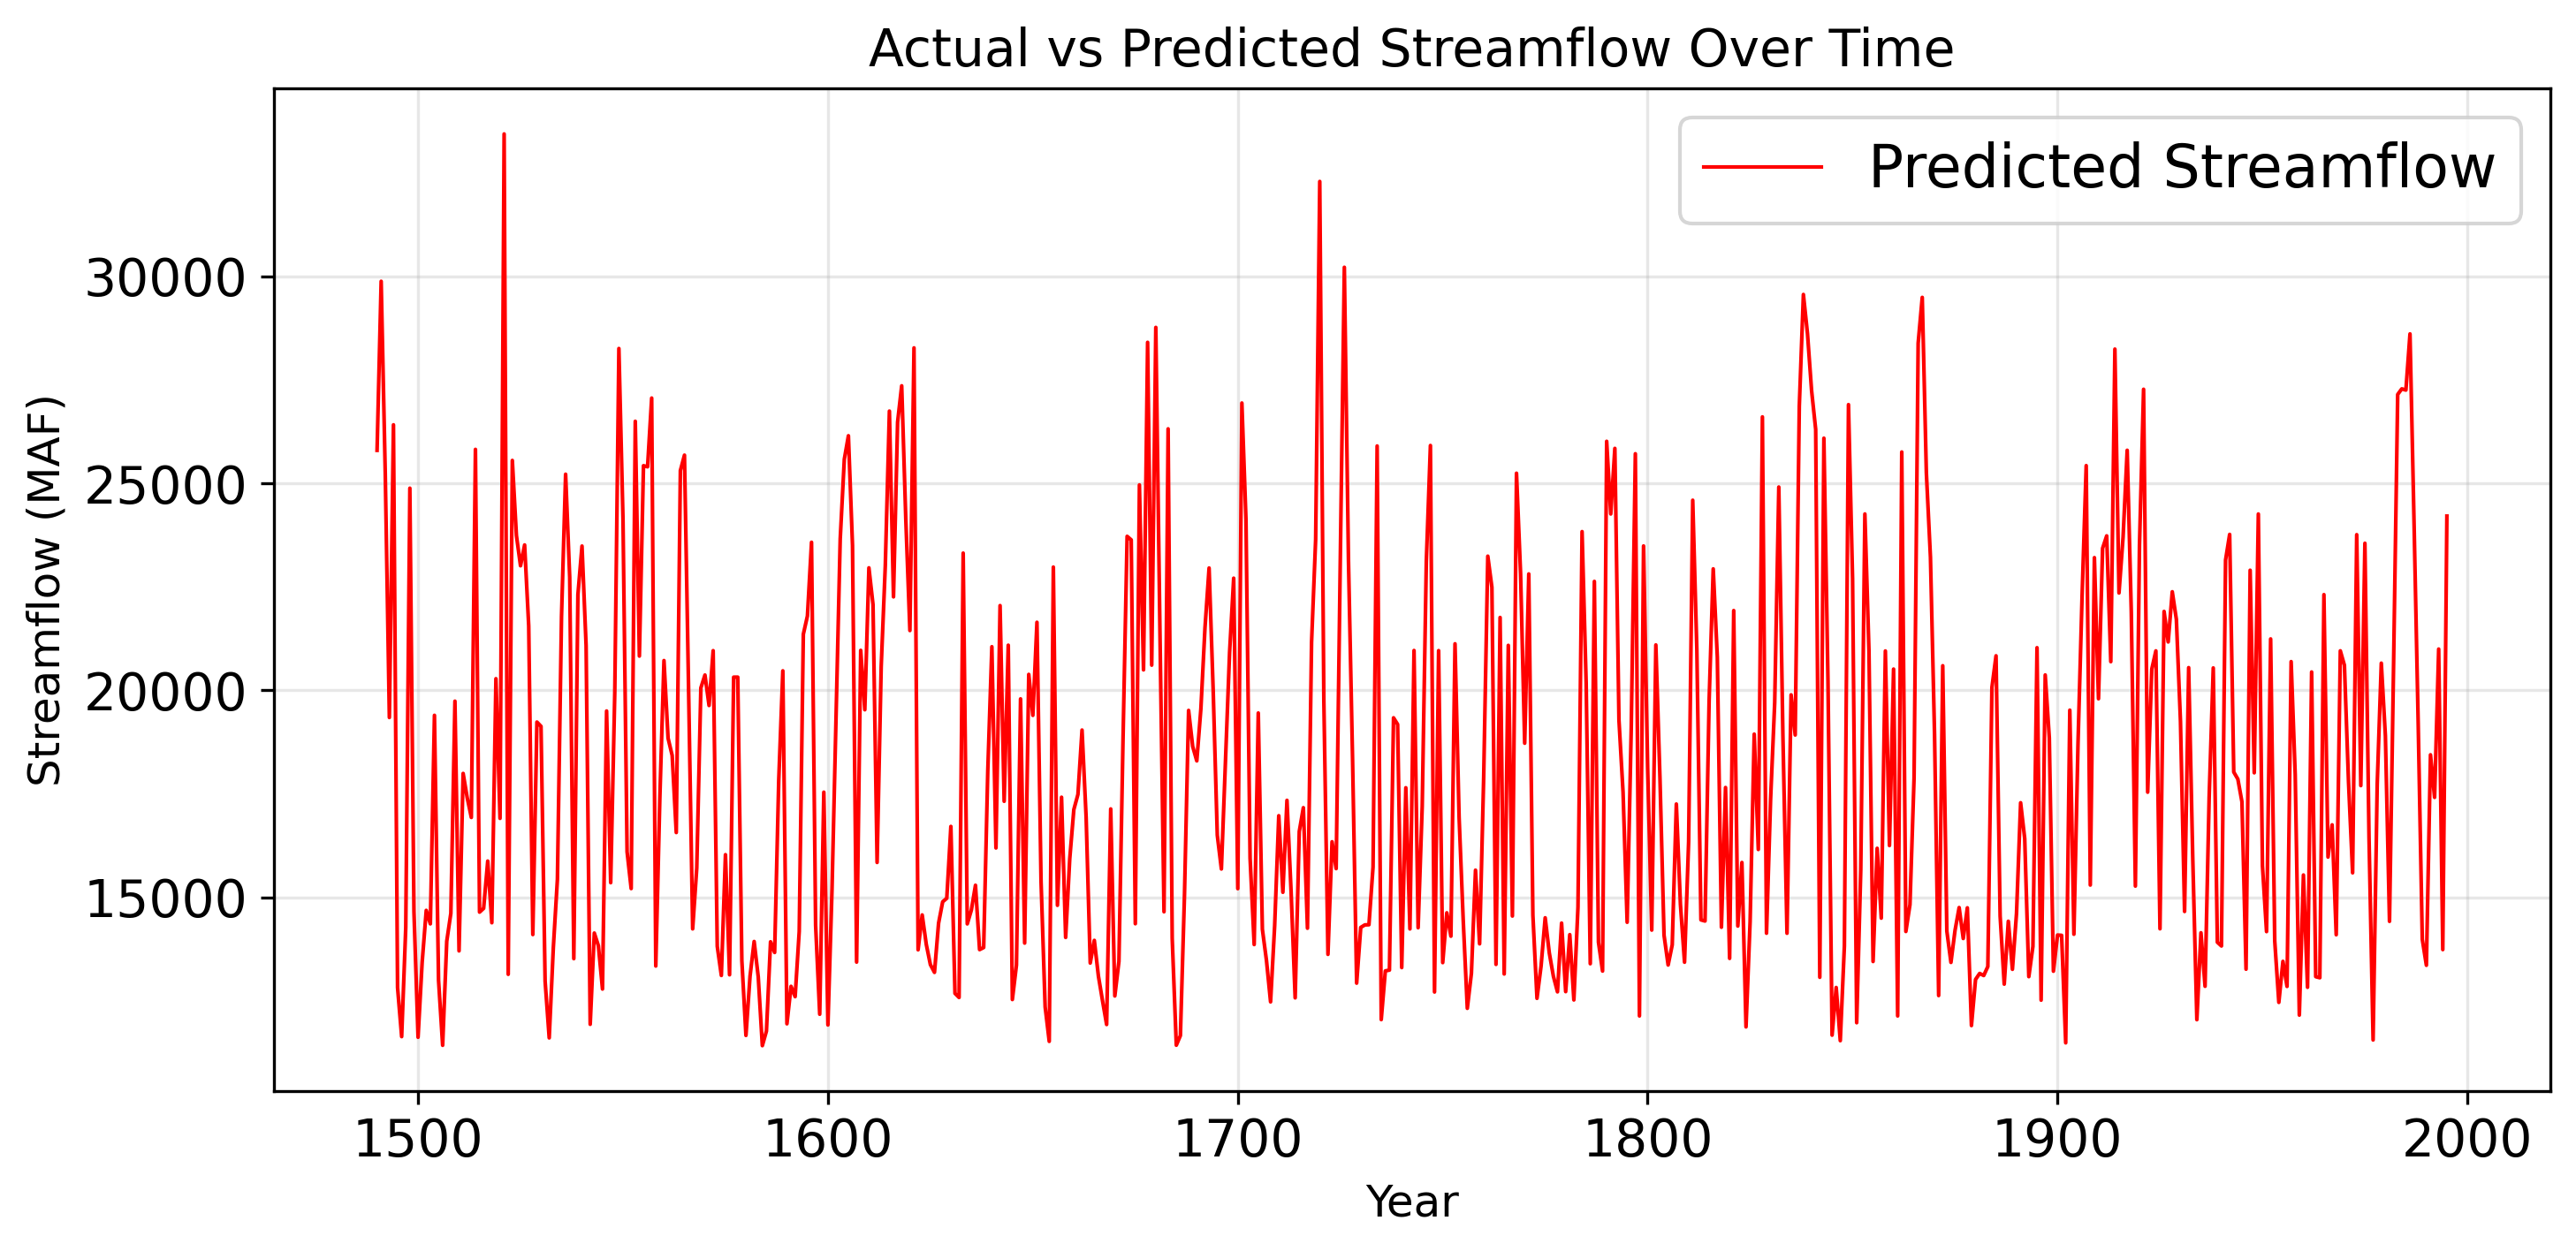

In [115]:
y_pred = pd.Series(model.predict(Z_pred).flatten(), index=Z_pred.index, name="Predicted")

plt.figure(figsize=(10,5))

# Plot actual measured streamflow
#plt.plot(y.index, y.values, label='Actual Streamflow', color='blue', linewidth=1)

# Plot NN predictions
plt.plot(y_pred.index, y_pred.values, label='Predicted Streamflow', color='red', linewidth=1)

plt.xlabel('Year', fontsize=12)
plt.ylabel('Streamflow (MAF)', fontsize=12)
plt.title('Actual vs Predicted Streamflow Over Time', fontsize=14)
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [116]:
df_out = pd.DataFrame({
    'Year': y_pred.index,
    'Reconstructed_Streamflow NN': y_pred
})

# Save to Excel
df_out.to_excel('Reconstructed_Streamflow - NN.xlsx', index=False)